# Design Optimization

This notebook goes over design optimization process by determining important aircraft state and finding optimized dimension around it

From the mission, we know that important aspects of the designed aircraft should be
* Flight Distance D - Covering long range survey
* Altitude Hight H - Optimal resolution for nest detection
* Speed VT - Speed of aircraft to cover area effectively
* TBD


The payload of the mission is a camera. An altitude $H$ and speed $VT$ will be determiend based on optimal hight and frame update rate of the camera. Therefore, sensor payload data must be used to compute optimal flight hight and speed.

Based on mission requirement and FAA regulation, we have constraints set up, as listed below:
* Aircraft Weight $\leq$ 12.5 lbs
* Aircraft Sizing requirements (TBA)

In [1]:
# Procedure for analysis
# 1. Find H, VT optimal based on sensor spec (GoPro Cameras)
# 2. From H, VT, and Flight Distance input, determine power required & battery amount
# 3. Based on battery amount & power source, estimate aircraft weight from statistical data of UAVs
# 4. From weight, Lift can be determined at steady flight // determine wing characteristic and subsequent drag characteristic
# 5. From wing characteristic, determine optimized aircraft sizing

In [2]:
# Unit Conversion
lbs2kg = 0.453592 # lbs to kg (Weight)
slugft2kgm = 1.35581795 # slug ft^2 to kg m^2 (Intertia)
mi2km = 1.60934 # Mi to Km (Distance)

In [3]:
import casadi as ca
from casadi import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

In [5]:
# 1. Camera Optimization
# Parameter
# Set up dictionary for camera's specification
# f: focal length

data = {'Hero5_Black': {'f': {'wide': 14, 'medium': 21, 'narrow': 28},
                        'sensor_size_h': 6.17, 'sensor_size_v': 4.55, 'Weight': 118,
                        'video_resolution': {'4K': {'wide': 30},
                                             '2.7K': {'wide': 60, 'medium': 48, 'narrow': 24},
                                             '1440p': {'wide': 60},
                                             '1080p': {'wide': 60, 'medium': 48, 'narrow': 30}}}
       } # Units: f: mm, sensor size: mm, Weight: g

def sensor_spec(model_name):
    '''
    This function takes name of camera model and output its specficiation
    
    Input: model_name (str)
    Output: specification (dic)
    '''
    specification = data[model_name]
    return specification

def parameter_set(input_vec, param):
    H = input_vec[0] # Altitude (m)
    D = input_vec[1]*mi2km # Flight Distance (m)
    Sw = input_vec[2] # Wing Span
    mass = input_vec[3]*lbs2kg # Mass of aircraft
    D_prop = input_vec[4] # Distance of Propeller
    n_prop = input_vec[5] # Propeller Speed (rev/s)
    VT = input_vec[6]
    
    ELEV = param[0]
    XCG = param[1]
    ALPHA = param[2]
    THETA = param[3]
    Q = param[4]
    
    x = ca.vertcat(VT, ALPHA, THETA, Q, H, D)
    u = ca.vertcat(ELEV, XCG, Sw, mass, D_prop, n_prop)
    
    return x, u

def constraint_func(specification, cam_type, resolution, x, u):
    '''
    Take camera spec, extract variables needed, and return constraint vector
    
    Input: specification (dic), cam_type, resolution (str), u (vec)
    Output: constraint vector with S, H, VT
    '''
    # Constant Values given
    CBAR = 17.5
    IYY = 4.1E6
    ZE = 2.0
    CDCLS = 0.042
    CLA = 0.085
    CMA = -0.022
    CMDE = -0.016
    CMQ = -16.0
    CMADOT = -6.0
    CLADOT = 0.0
    RTOD = 57.29578
    GD = 32.17
    CL0 = 0.2
    CD0 = 0.016
    CM0 = 0.05
    DCDG = 0.0
    DCMG = 0.0
    
    # Parameter Setup   
    Vmax = x[0]
    ALPHA = 0
    ALPHA_deg = 0 * RTOD
    THETA = 0
    Q = 0
    H = x[4]
    D = x[5]
    
    ELEV = 0
    XCG = 0.25
    Sw = u[2]
    mass = u[3]
    D_prop = u[4]
    n_prop = u[5]    

    # Air Property Model
    R0 = 2.377E-3
    TFAC = 1.0 - (0.703E-5) * H
    T = 519.0 * TFAC
    rho = R0 * (TFAC**4.14) # Air Density at given height H
    
    # Sensor Model:
    f = float(specification['f'][cam_type])*1e-3 # Focal Lnegth (m)
    h = float(specification['sensor_size_h'])*1e-3 # Lense Height (m)
    w_camera = float(specification['Weight'])*1e-3 # Camera Weight (kg)
    #screen_resolution = specification['video_resolution'][resolution]
    #frame_rate = float(screen_resolution[cam_type]) # Sensor frame rate (fps)
    P = 0.5 # Percentage of required forward overlap    
    
    inside = h/(2*f)
    FOV = 2*H*ca.atan(inside)
    S = 2*H*ca.tan(FOV/2)
    #Vmax = frame_rate / (S * (1 - P))
    frame_rate = VT*(S*(1 - P))
    t_exp = D / Vmax # Flight Time (sec)
    Width = Vmax*t_exp
    A = S*Width
    
    # Aerodynamic Property
    SALP = ca.sin(ALPHA)
    CALP = ca.cos(ALPHA)
    GAM = THETA - ALPHA
    SGAM = ca.sin(GAM)
    CGAM = ca.cos(GAM)
    CL = CL0 + CLA * ALPHA_deg
    CM = DCMG + CM0 + CMA * ALPHA_deg + CMDE * ELEV + CL*(XCG-0.25)
    CD = DCDG + CD0 + CDCLS * (CL**2)
    
    # Generic Aircraft Model
    weight = mass * lbs2kg # = Lift
    q_inf = 0.5 * rho * VT**2
    Sw = weight / (q_inf * CL)
    kT = 0.5 # Thrust Coefficient
    THR = kT * rho * n_prop**2 * D_prop**4
    D = q_inf * CD * Sw
    
    QS = q_inf * S
    VT_dot = (THR - D) / mass
    ALPHA_dot = (-1 * THR * SALP - QS * CL + mass * (VT * Q + GD * CGAM)) / (mass * VT + QS * CLADOT)
    THETA_dot = Q
    D = 0.5 * CBAR * (CMQ*Q + CMADOT*ALPHA_dot) / Vmax
    Q_dot = (QS * CBAR * (CM + D) + THR * ZE + CALP) / IYY
    
    # Output
    opt_vec = ca.vertcat(A, H, VT, Sw, frame_rate)
    xd = ca.vertcat(VT_dot, ALPHA_dot, THETA_dot, Q_dot)
    
    return opt_vec, xd

def objective_function(opt_vec, xd):
    '''
    Calculate objective function of the system
    Maximize: Sweep Area S, Altitude H
    Minimize: Velocity VT
    
    Input: constraint (vec)
    Output: trim cost
    '''
    A = opt_vec[0]
    H = opt_vec[1]
    VT = opt_vec[2]
    Sw = opt_vec[3]
    frame_rate = opt_vec[4]
    
    VT_dot = xd[0]
    A_dot = xd[1]
    T_dot = xd[2]
    Q_dot = xd[3]
    
    return 100*(1/A)**2 + 1000*(VT)**2 - 10*(1/H) + 10*(Sw)**2 + (1/frame_rate)**2# + VT_dot**2 + 100*A_dot**2 + 10*(T_dot**2 + Q_dot**2)

In [6]:
# Symbolic Variable Setup
# u = [H, D, Sw, mass, D_prop, n_prop]
H = ca.SX.sym('H')
D = ca.SX.sym('D')
Sw = ca.SX.sym('Sw')
mass = ca.SX.sym('mass')
D_prop = ca.SX.sym('D_prop')
n_prop = ca.SX.sym('n_prop')
VT = ca.SX.sym('VT')

input_vec = ca.vertcat(H, D, Sw, mass, D_prop, n_prop, VT)

ELEV = ca.SX.sym('ELEV')
XCG = ca.SX.sym('XCG')
ALPHA = ca.SX.sym('ALPHA')
THETA = ca.SX.sym('THETA')
Q = ca.SX.sym('Q')

param = ca.vertcat(ELEV, XCG, ALPHA, THETA, Q)

In [7]:
sensor = sensor_spec('Hero5_Black')
cam_type = 'wide'
resolution = '4K'
x, u = parameter_set(input_vec, param)
opt_vec, xd = constraint_func(sensor, cam_type, resolution, x, u)
opt = objective_function(opt_vec, xd)

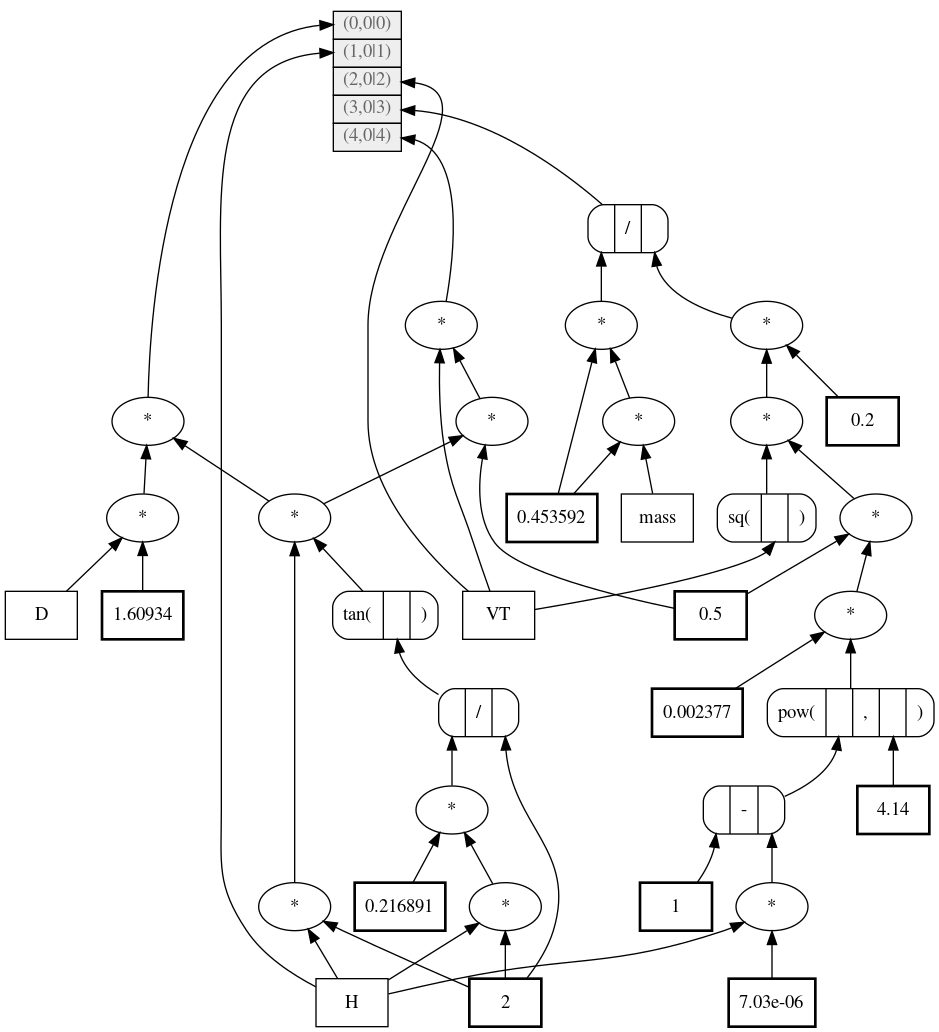

In [8]:
draw_graph(opt_vec)

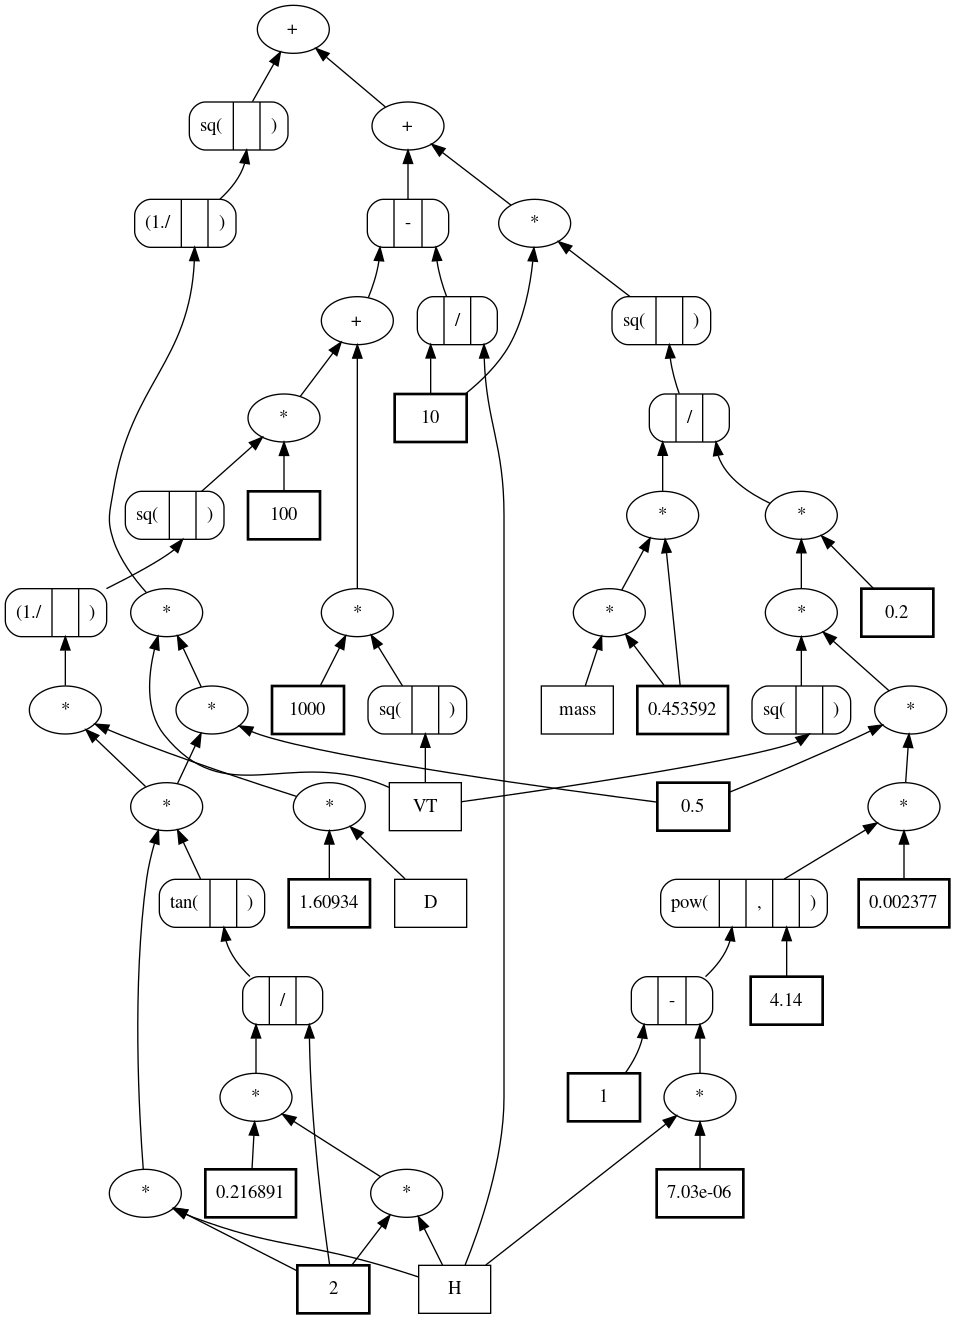

In [9]:
draw_graph(opt)

In [12]:
# Sensor Payload Optimization
def payload_optimization(x0, sensor, cam_type, resolution):
    '''
    Setup nlp solver for optimizing Altitude H & Velocity VT
    
    Input: x0 (initial guess, vec), sensor (dic), f (str)
    Output: x_opt (vec)
    '''
    x_design = ca.SX.sym('x_design', 7)
    x, u = parameter_set(x_design, param)
    opt_vec, xd = constraint_func(sensor, cam_type, resolution, x, u)
    trim_cost = objective_function(opt_vec, xd)
    nlp = {'x': x_design, 'f': trim_cost}
    S = nlpsol('S', 'ipopt', nlp, {'print_time': 0, 'ipopt': {'sb': 'yes','print_level': 0}})
    result = S(x0=x0, lbg=0, ubg=0, lbx = [10, 0, 0, 12, 0.5, 500, 0], ubx = [120, 15, 20, 13, 1.5, 3000, 200])
    x_opt = result['x']
    print('Optimized Height: ', x_opt[0], 'm')
    print('Optimized VT: ', x_opt[1], 'm/s')
    print('Calculated Trim Cost: ', result['f'])
    return x_opt

In [13]:
# Initial Guess for optimization
# x0 = [H(m), D(mi), Sw(ft), mass(lbs), D_prop(m), n_prop(rev/s)]
x0 = [60, 12, 10, 12.5, 0.75, 2000, 100]
x_opt = payload_optimization(x0, sensor, cam_type, resolution)

RuntimeError: .../casadi/core/nlpsol.cpp:120: Cannot create 'S' since [VT] are free.